<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import tensorflow as tf
tf.random.set_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import tensorflow.keras as keras
print("Keras:{}".format(keras.__version__))

import os
import sys
print('Python interpreter and version:',sys.version)

NumPy:1.18.1
Pandas:0.25.1
TensorFlow:2.2.0
Keras:2.3.0-tf
Python interpreter and version: 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [3]:
dsroot = os.path.join(os.path.expanduser('~'),
                      'datasets',
                      'kaggle-retailrocket')
os.listdir(dsroot)

FileNotFoundError: [Errno 2] No such file or directory: '/home/my/datasets/kaggle-retailrocket'

In [4]:
events = pd.read_csv('data/events.csv')
print('Event data\n',events.head())

Event data
        timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN


In [5]:
print('Unique counts:',events.nunique())

Unique counts: timestamp        2750455
visitorid        1407580
event                  3
itemid            235061
transactionid      17672
dtype: int64


In [6]:
print('Kind of events:',events.event.unique())

Kind of events: ['view' 'addtocart' 'transaction']


In [7]:
events.event.replace(to_replace=dict(view=1, 
                                     addtocart=2, 
                                     transaction=3), 
                     inplace=True)
events.drop(['transactionid'],axis=1,inplace=True)
events.drop(['timestamp'],axis=1,inplace=True)
#events = events.sample(frac=1).reset_index(drop=True)
events = events.reindex(np.random.permutation(events.index))
#events=events[0:100000]

In [13]:
split_1 = int(0.8 * len(events))
split_2 = int(0.9 * len(events))
train = events[:split_1]
valid = events[split_1:split_2]
test = events[split_2:]
print(train.head())
print(valid.head())
print(test.head())

         visitorid  event  itemid
1621867     896963      1  264947
1060311    1102098      1  431592
114317     1241997      1  283584
1658382     198153      1   97879
2173151    1278262      1  218178
         visitorid  event  itemid
1903213      85425      1  344338
1722815    1085328      1   59691
1388040    1366284      1  248032
2669880     478634      1  388940
1893864    1052918      1  328647
         visitorid  event  itemid
1004940     193171      1   11565
642906      704648      1  262522
902126       10212      1   46971
569976      753933      1   29489
1517206     261457      1  154821


In [14]:
n_visitors = events.visitorid.nunique()
n_items = events.itemid.nunique()
n_latent_factors = 5

In [15]:
from tensorflow.keras.layers import Input, Embedding, Flatten
item_input = Input(shape=[1],name='Items')
item_embed = Embedding(n_items + 1,
                       n_latent_factors, 
                       name='ItemsEmbedding')(item_input)
item_vec = Flatten(name='ItemsFlatten')(item_embed)

visitor_input = Input(shape=[1],name='Visitors')
visitor_embed = Embedding(n_visitors + 1,
                          n_latent_factors,
                          name='VisitorsEmbedding')(visitor_input)
visitor_vec = Flatten(name='VisitorsFlatten')(visitor_embed)

dot_prod = keras.layers.dot([item_vec, visitor_vec],axes=[1,1],
                             name='DotProduct') 
model = keras.Model([item_input, visitor_input], dot_prod)
model.compile('adam', 'mse')

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Items (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Visitors (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
ItemsEmbedding (Embedding)      (None, 1, 5)         1175310     Items[0][0]                      
__________________________________________________________________________________________________
VisitorsEmbedding (Embedding)   (None, 1, 5)         7037905     Visitors[0][0]                   
____________________________________________________________________________________________

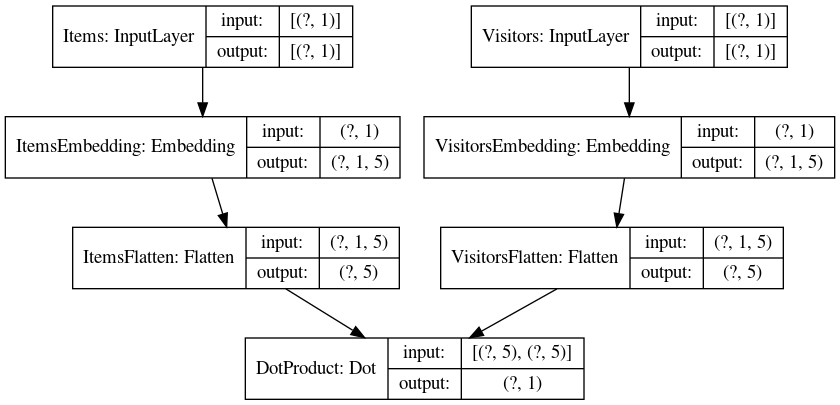

In [17]:
keras.utils.plot_model(model, 
                       to_file='model.png', 
                       show_shapes=True, 
                       show_layer_names=True)
from IPython import display
display.display(display.Image('model.png'))

In [18]:
model.fit([train.visitorid, train.itemid], train.event, epochs=50)

Epoch 1/50


InvalidArgumentError:  indices[0,0] = 716029 is not in [0, 235062)
	 [[node model_1/ItemsEmbedding/embedding_lookup (defined at <ipython-input-18-213018d0ebba>:1) ]] [Op:__inference_train_function_764]

Errors may have originated from an input operation.
Input Source operations connected to node model_1/ItemsEmbedding/embedding_lookup:
 model_1/ItemsEmbedding/embedding_lookup/531 (defined at /home/my/anaconda3/lib/python3.7/contextlib.py:112)

Function call stack:
train_function


In [13]:
score = model.evaluate([test.visitorid, test.itemid], test.event)
print('mean squared error:', score)

275611/275611 [==============================] - 3s 12us/step
mean squared error: 5.66910962683725e+18


In [14]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense

n_lf_visitor = 5
n_lf_item = 5

item_input = Input(shape=[1],name='Items')
item_embed = Embedding(n_items + 1,
                           n_lf_visitor, 
                           name='ItemsEmbedding')(item_input)
item_vec = Flatten(name='ItemsFlatten')(item_embed)

visitor_input = Input(shape=[1],name='Visitors')
visitor_embed = Embedding(n_visitors + 1, 
                              n_lf_item,
                              name='VisitorsEmbedding')(visitor_input)
visitor_vec = Flatten(name='VisitorsFlatten')(visitor_embed)

concat = keras.layers.concatenate([item_vec, visitor_vec], name='Concat')
fc_1 = Dense(80,name='FC-1')(concat)
fc_2 = Dense(40,name='FC-2')(fc_1)
fc_3 = Dense(20,name='FC-3', activation='relu')(fc_2)

output = Dense(1, activation='relu',name='Output')(fc_3)

optimizer = keras.optimizers.Adam(lr=0.001)
model = keras.Model([item_input, visitor_input], output)
model.compile(optimizer=optimizer,loss= 'mse')

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Items (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Visitors (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
ItemsEmbedding (Embedding)      (None, 1, 5)         1175310     Items[0][0]                      
__________________________________________________________________________________________________
VisitorsEmbedding (Embedding)   (None, 1, 5)         7037905     Visitors[0][0]                   
__________________________________________________________________________________________________
ItemsFlatt

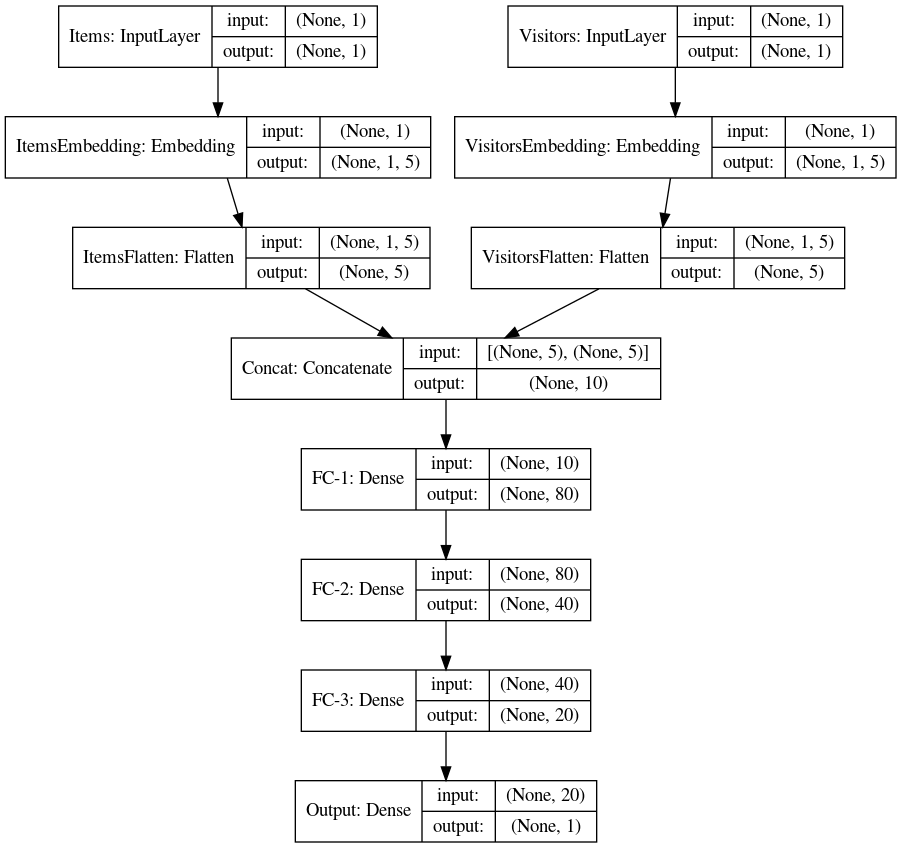

In [16]:
keras.utils.plot_model(model, 
                       to_file='model.png', 
                       show_shapes=True, 
                       show_layer_names=True)
from IPython import display
display.display(display.Image('model.png'))

In [17]:
model.fit([train.visitorid, train.itemid], train.event, epochs=50)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
2204880/2204880 [==============================] - 655s 297us/step - loss: 0.0626
Epoch 2/50
2204880/2204880 [==============================] - 667s 302us/step - loss: 0.0567
Epoch 3/50
2204880/2204880 [==============================] - 637s 289us/step - loss: 0.0565
Epoch 4/50
2204880/2204880 [==============================] - 637s 289us/step - loss: 0.0565
Epoch 5/50
2204880/2204880 [==============================] - 637s 289us/step - loss: 0.0565
Epoch 6/50
2204880/2204880 [==============================] - 637s 289us/step - loss: 0.0565
Epoch 7/50
2204880/2204880 [==============================] - 637s 289us/step - loss: 0.0565
Epoch 8/50
2204880/2204880 [==============================] - 637s 289us/step - loss: 0.0565
Epoch 9/50
2204880/2204880 [==============================] - 637s 289us/step - loss: 0.0565
Epoch 10/50
2204880/2204880 [==============================] - 637s 289us/step - loss: 0.0565
Epoch 11/50
2204880/2204880 [==============================] - 637s 2

In [18]:
score = model.evaluate([test.visitorid, test.itemid], test.event)
print('mean squared error:', score)

275611/275611 [==============================] - 4s 14us/step
mean squared error: 0.05709125054560985
